<a href="https://colab.research.google.com/github/LikaOkudzhava/BrainyScan/blob/main/Alzheimer_Xception_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import os
import cv2

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from tqdm import tqdm

import keras
from keras.callbacks import EarlyStopping,ModelCheckpoint

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import zipfile
from google.colab import drive

gdrive = '/content/drive'
drive.mount(gdrive, force_remount=False)

gdisk = os.path.join(gdrive, 'MyDrive')

filename = 'Copy of preprocessed (1)'

archive_path = os.path.join(gdisk, filename)
with zipfile.ZipFile('/content/drive/MyDrive/Copy of preprocessed (1).zip', 'r') as zip_ref:
 zip_ref.extractall(f'{filename}_extracted')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
preprocessing_function=tf.keras.applications.xception.preprocess_input


In [4]:


dataset_dir = '/content/Copy of preprocessed (1)_extracted/data/Preprocessed'
image_size = (299, 299)
batch_size = 32


datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input,
    horizontal_flip=True
)

train_generator = datagen.flow_from_directory(
    os.path.join(dataset_dir, 'train'),
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = datagen.flow_from_directory(
    os.path.join(dataset_dir, 'test'),
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

val_generator = datagen.flow_from_directory(
    os.path.join(dataset_dir, 'val'),
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)


Found 30799 images belonging to 4 classes.
Found 6600 images belonging to 4 classes.
Found 6601 images belonging to 4 classes.


In [5]:
from tensorflow.keras.applications import Xception
from tensorflow.keras import layers, models, Input

image_size = (299, 299)

xception_model = Xception(input_shape=(image_size[0], image_size[1], 3),include_top=False,weights='imagenet',pooling='avg')

inputs = Input(shape=(image_size[0], image_size[1], 3))
x = xception_model(inputs, training=False)
x = layers.BatchNormalization()(x)
x = layers.Dense(2048, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(4, activation='softmax')(x)

model = models.Model(inputs, outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()






83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │     4,196,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,180,588 (103.69 MB)

 Trainable params: 27,115,820 (103.44 MB)

 Non-trainable params: 64,768 (253.00 KB)

In [7]:

xception_model.trainable = False

#  unfreeze the last 50 layers
for layer in xception_model.layers[-50:]:
    layer.trainable = True



In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)]



In [9]:
hist = model.fit(train_generator,validation_data=val_generator,epochs=25,callbacks=callbacks)



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
963/963 ━━━━━━━━━━━━━━━━━━━━ 486s 465ms/step - accuracy: 0.6969 - loss: 0.8325 - val_accuracy: 0.8629 - val_loss: 0.4462 - learning_rate: 0.0010
Epoch 2/25
963/963 ━━━━━━━━━━━━━━━━━━━━ 423s 439ms/step - accuracy: 0.9173 - loss: 0.2307 - val_accuracy: 0.9271 - val_loss: 0.2260 - learning_rate: 0.0010
Epoch 3/25
963/963 ━━━━━━━━━━━━━━━━━━━━ 424s 440ms/step - accuracy: 0.9614 - loss: 0.1079 - val_accuracy: 0.9795 - val_loss: 0.0603 - learning_rate: 0.0010
Epoch 4/25
963/963 ━━━━━━━━━━━━━━━━━━━━ 423s 439ms/step - accuracy: 0.9747 - loss: 0.0739 - val_accuracy: 0.9717 - val_loss: 0.0848 - learning_rate: 0.0010
Epoch 5/25
963/963 ━━━━━━━━━━━━━━━━━━━━ 423s 440ms/step - accuracy: 0.9741 - loss: 0.0780 - val_accuracy: 0.9853 - val_loss: 0.0408 - learning_rate: 0.0010
Epoch 6/25
963/963 ━━━━━━━━━━━━━━━━━━━━ 423s 439ms/step - accuracy: 0.9811 - loss: 0.0559 - val_accuracy: 0.9464 - val_loss: 0.1444 - learning_rate: 0.0010
Epoch 7/25
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy

In [10]:
score, acc= model.evaluate(test_generator)
print('Val Loss =', score)
print('Val Accuracy =', acc)

207/207 ━━━━━━━━━━━━━━━━━━━━ 51s 244ms/step - accuracy: 0.9957 - loss: 0.0152
Val Loss = 0.013070451095700264
Val Accuracy = 0.9956060647964478


In [11]:

test_loss, test_acc = model.evaluate(test_generator)
print(f" Final Test Accuracy: {test_acc:.4f}")

207/207 ━━━━━━━━━━━━━━━━━━━━ 47s 225ms/step - accuracy: 0.9959 - loss: 0.0116
 Final Test Accuracy: 0.9959


In [12]:
hist_=pd.DataFrame(hist.history)

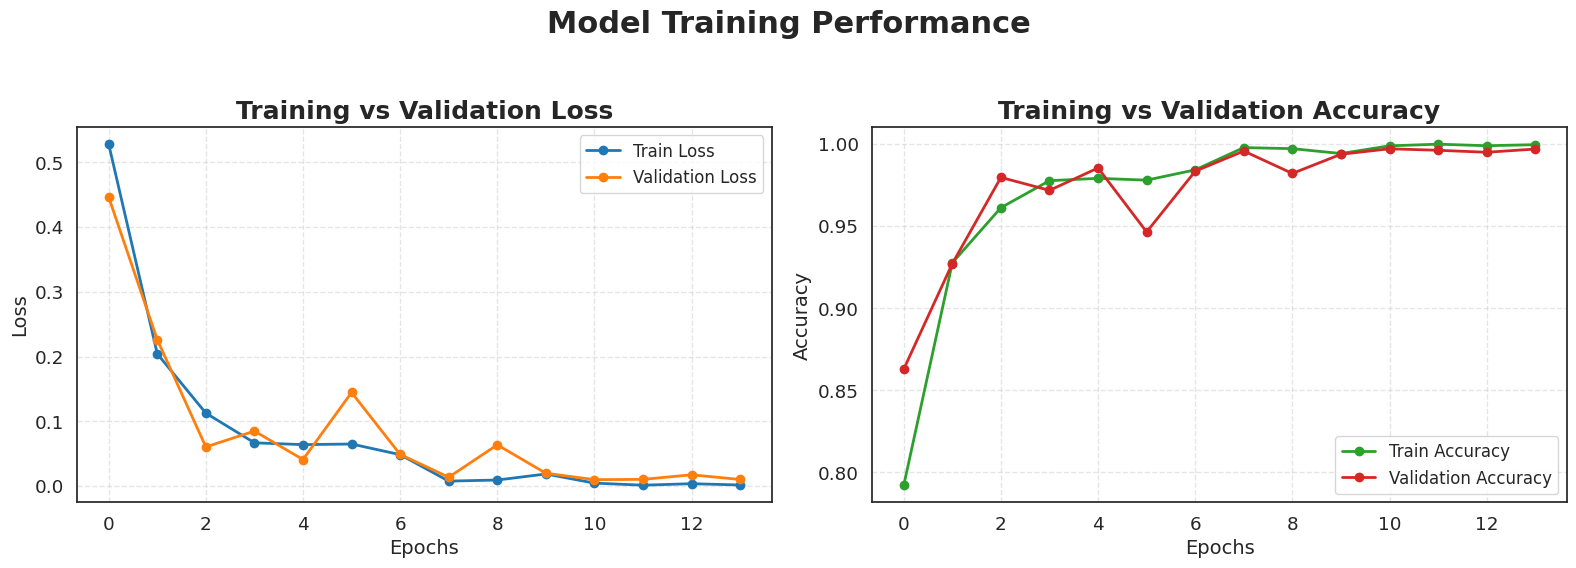

In [44]:
plt.figure(figsize=(16,6))

#  Loss Plot
plt.subplot(1, 2, 1)
plt.plot(hist_['loss'], label='Train Loss', color='#1f77b4', linewidth=2, marker='o')
plt.plot(hist_['val_loss'], label='Validation Loss', color='#ff7f0e', linewidth=2, marker='o')
plt.title('Training vs Validation Loss', fontsize=18, fontweight='bold')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(hist_['accuracy'], label='Train Accuracy', color='#2ca02c', linewidth=2, marker='o')
plt.plot(hist_['val_accuracy'], label='Validation Accuracy', color='#d62728', linewidth=2, marker='o')
plt.title('Training vs Validation Accuracy', fontsize=18, fontweight='bold')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)

plt.suptitle('Model Training Performance', fontsize=22, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



In [14]:
y_test =test_generator.classes
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions,axis=1)
y_test = np.ravel(y_test)
y_pred = np.ravel(y_pred)
df = pd.DataFrame({'Actual': y_test, 'Prediction': y_pred})

207/207 ━━━━━━━━━━━━━━━━━━━━ 53s 238ms/step


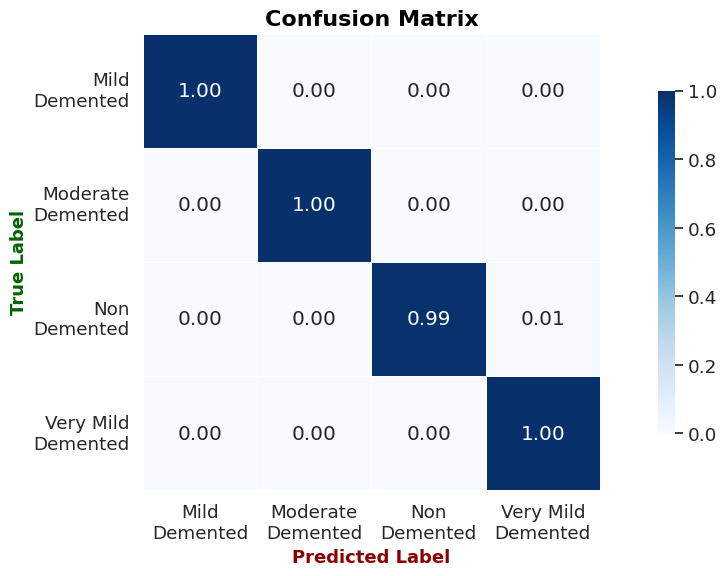

In [45]:
#confusion matrix
CM = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix
CM_percent = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]


class_names = ['Mild\nDemented','Moderate\nDemented','Non\nDemented','Very Mild\nDemented']

plt.figure(figsize=(12,6))
sns.set(font_scale=1.2)
sns.set_style("white")

# heatmap
ax = sns.heatmap(CM_percent,annot=True,fmt=".2f",cmap="Blues",xticklabels=class_names,yticklabels=class_names,linewidths=0.5,square=True,
    cbar_kws={"shrink": 0.75})

plt.xticks(rotation=0, ha='center')
plt.yticks(rotation=0)
plt.xlabel('Predicted Label', fontsize=13, fontweight='bold', color='darkred')
plt.ylabel('True Label', fontsize=13, fontweight='bold', color='darkgreen')
plt.title('Confusion Matrix', fontsize=16, fontweight='bold', color='black')
plt.tight_layout()
plt.show()




In [17]:
class_names = ['MildDemented','ModerateDemented', 'NonDemented', 'VeryDemented']
ClassificationReport = classification_report(y_test, y_pred, target_names=class_names)
print('Classification Report is:\n', ClassificationReport)


Classification Report is:
                   precision    recall  f1-score   support

    MildDemented       0.99      1.00      1.00      1500
ModerateDemented       1.00      1.00      1.00      1500
     NonDemented       1.00      0.99      0.99      1920
    VeryDemented       0.99      1.00      0.99      1680

        accuracy                           1.00      6600
       macro avg       1.00      1.00      1.00      6600
    weighted avg       1.00      1.00      1.00      6600

